In [1]:
using LibPQ, Tables, Plots, HTTP, CSV, Random, StatsBase, 
FreqTables, SQLite, Base, Dates, JuliaDB, StatsPlots, Statistics, StructArrays, NPFinancial, DataStructures,
Random, Distributions
using Base: show_supertypes
plotly()


┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/sharath/.julia/packages/Plots/qZHsp/src/backends.jl:363


Plots.PlotlyBackend()

In [2]:
using Distributions

In [ ]:
using Pkg;
Pkg.add("Distributions");Pkg.add("DataStructures")


In [3]:
conn = LibPQ.Connection("dbname=sharath")
sqlite = SQLite.DB()

SQLite.DB(":memory:")

In [4]:
Random.seed!(123);
function fmt(d::DateTime)
    Dates.format(d, "yyyy-mm-dd")
end
function p2(p1::Number, r::Number, t::Number)
    return Float64(p1)*((1+Float64(r))^Float64(t))
end

function t(p1::Number, p2::Number, r::Number)
    return log(Float64(p2)/Float64(p1)) / log(1+Float64(r))
end

function p1(p2::Number, r::Number, t::Number)
    return Float64(p2)/((1+Float64(r))^Float64(t))
end

function r(p1::Number, p2::Number, t::Number)
    power = log(Float64(p2)/Float64(p1))/Float64(t)
    return exp(power) - 1
end

function emi(p1::Number, r::Number, t::Number)
    x::Float64 = (1.0 + Float64(r))^Float64(t)
    return Float64(p1) * Float64(r) * x / (x - 1)
end
function splt(s, delim=r"\s+")
    ar = split(s, delim)
    ar = strip.(ar)
    ar = filter(s -> s != Missing && length(s)>0, ar)
    return ar
end
function doplot(x, y)
#     plot(x, y; hover=fmt.(x).*"   ".*fmt.(y), size=(1700, 400,))
    plot(x, y;hover=string.(x).*"   ".*string.(y), size=(1400, 400,))

end
function delme(l::MutableLinkedList, toDelete::DataStructures.ListNode)
    isempty(l) && throw(ArgumentError("List must be non-empty"))
    last::DataStructures.ListNode = toDelete.prev.prev
    next::DataStructures.ListNode = toDelete
    last.next = next
    next.prev = last
    l.len -= 1
end

import Base: iterate
mutable struct FastListNode{T}
    prev::Int
    next::Int
    data::T
    function FastListNode{T}() where T
        node = new{T}()
        return node
    end
end
mutable struct FastList{T}
    len::Int
    sz::Int
    list::Vector{FastListNode{T}}
    function FastList{T}(l::Int) where T
        fl = new{T}()
        fl.list = Vector{FastListNode{T}}(undef, l)
        for i in 1:l
            fl.list[i] = FastListNode{T}()
        end
        fl.len = 0
        fl.list[1].prev = fl.list[1].next = 1
        fl.sz = 2 # the first node is the root
        return fl
    end
end

function push!(fl::FastList{T}, data::T) where T
    list::Vector{FastListNode{T}} = fl.list
    node = list[fl.sz]
    node.prev = list[1].prev
    node.next = 1
    node.data = data

    list[list[1].prev].next = fl.sz
    list[1].prev = fl.sz
    fl.len += 1
    fl.sz += 1
end

function del(fl::FastList{T}, node::FastListNode{T}) where T
    fl.len==0 && throw(ArgumentError("List must be non-empty"))
    list::Vector{FastListNode{T}} = fl.list
    list[node.prev].next = node.next
    list[node.next].prev = node.prev
    fl.len -= 1
end

function reset!(fl::FastList{T}) where T
    fl.len = 0
    fl.list[1].prev = fl.list[1].next = 1
    fl.sz = 2 # the first node is the root
end

function Base.iterate(fl::FastList{T}) where T
    if fl.len == 0
        return nothing
    end
    list::Vector{FastListNode{T}} = fl.list
    return (list[list[1].next], list[list[1].next].next)
end

function iterate(fl::FastList{T}, n::Int) where T
    if n==1
        return nothing
    end
    return (fl.list[n], fl.list[n].next)

end

function pr(fl::FastList)
    for node in fl
        println(node.data)
    end
end


pr (generic function with 1 method)

In [5]:
# s is the stock prices. it is the output variable. 
# ϕ is a temporary array which will be used to hold the normal distribution
function weiner(days::Int, μ::Float64, σ::Float64, s::Union{Vector{Float64}, Nothing}=nothing, 
        ϕ::Union{Vector{Float64}, Nothing}=nothing, dist::Union{Normal{Float64}, Nothing}=nothing)
    #s = Vector{Float64}(undef, days)
    if s == nothing
        s = Vector{Float64}(undef, days)
    end
    if ϕ == nothing
        ϕ = Vector{Float64}(undef, days)
    end
    if dist == nothing
        dist = Normal(0, 1)
    end
    s[1] = 100
    a::Float64 = μ/365.0
    b::Float64 = σ/sqrt(365.0)
    rand!(dist, ϕ)
    for i::Int in 2:days
        s[i] = s[i-1]*(1 + a + ϕ[i]*b)
    end  
    return s
end

function downscale(Y::Vector{Float64}, points::Int)
    days::Int = length(Y)
    step::Float64 = 1
    if days > points
        step = days / points
    end
    println(step)
    XX = Vector{Float64}(undef, 0)
    YY = Vector{Float64}(undef, 0)
    for i in 1:step:days
        push!(XX, Int(i))
        push!(YY, Y[min(days, Int(round(i)))])
    end
    return XX, YY
end
days = 10000
μ, σ = 10.0/100, 30.0/100
# X, Y = downscale(weiner(days, μ, σ), 5000)
# doplot(X, Y)


(0.1, 0.3)

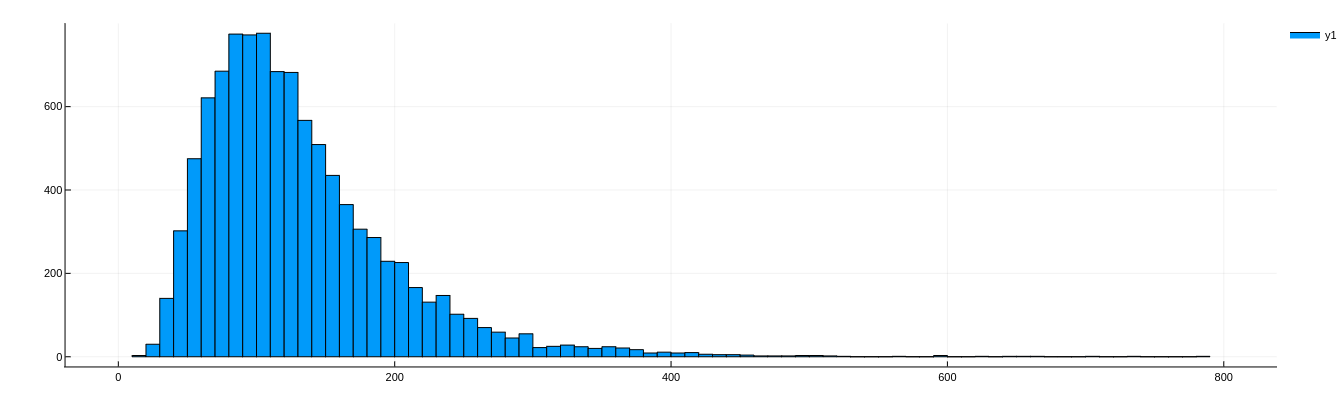

In [6]:
function monteCarlo()
    runs::Int = 10000
    days::Int = 1000
    s::Vector{Float64} = Vector{Float64}(undef, days)
    ϕ::Vector{Float64} = Vector{Float64}(undef, days)
    dist::Normal = Normal(0, 1)
    μ::Float64, σ::Float64 = 10.0/100, 30.0/100
    last::Vector{Float64} = Vector{Float64}(undef, runs)
    for run::Int in 1:runs
        weiner(days, μ, σ, s, ϕ, dist)
        last[run] = s[end]
    end
    histogram(last)
end
monteCarlo()

  3.942740 seconds (7.32 M allocations: 391.517 MiB, 0.94% gc time)


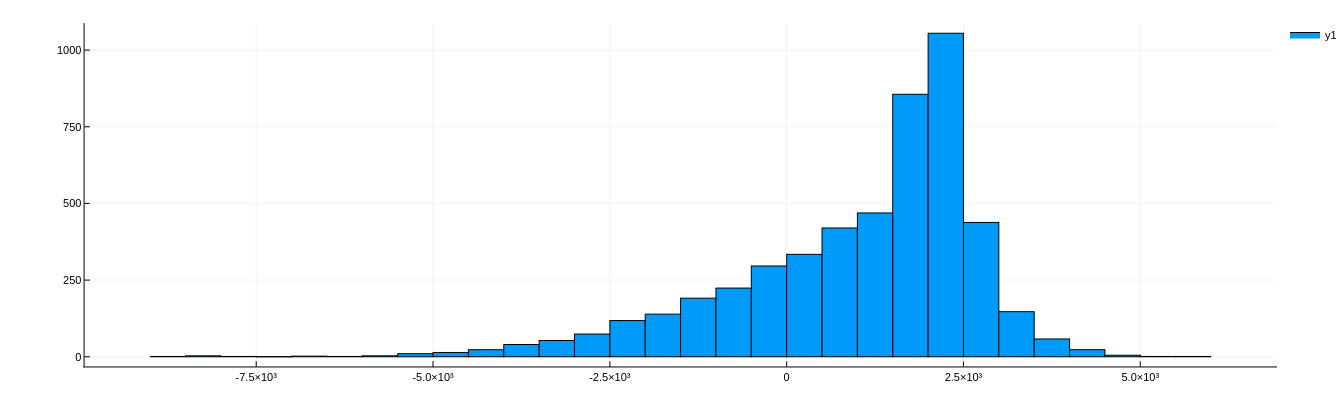

In [16]:
# Strategy: buy a stock every day, sell it when it hits cagr of 10%. or a maximum of 1000 days
function simulate()
    runs::Int = 5000
    wallets::Vector{Float64} = Vector{Float64}(undef, runs)
    
    rateThreshold::Float64 = .1; investDays::Int = 365*3; redeemDays::Int=365; days = investDays + redeemDays; 
    μ::Float64=.1; σ::Float64=.3; ll = FastList{Tuple{Int, Float64}}(4000);
    s::Union{Vector{Float64}, Nothing}=Vector{Float64}(undef, days); 
        ϕ::Union{Vector{Float64}, Nothing}=Vector{Float64}(undef, days); dist::Union{Normal{Float64}, Nothing}=Normal(0, 1);
    
    for run::Int in 1:runs
        wallets[run] = oneRun(rateThreshold, investDays, redeemDays, μ, σ, ll, s, ϕ, dist)
        reset!(ll)
    end
    histogram(wallets)
    
end

function oneRun(rateThreshold::Float64, investDays::Int, redeemDays::Int, μ::Float64, σ::Float64, ll::FastList{Tuple{Int, Float64}}, 
        s::Union{Vector{Float64}, Nothing}=nothing, 
        ϕ::Union{Vector{Float64}, Nothing}=nothing, dist::Union{Normal{Float64}, Nothing}=nothing)
    days::Int = investDays+redeemDays
    s = weiner(days, μ, σ, s, ϕ, dist)
#     daysToRedeem = Vector{Int}(undef, days)
#     fill!(daysToRedeem, 0)
#     display(doplot(collect(1:days), s))
    
    minWallet = 0
    wallet::Float64 = 0
    for day::Int in 1:days
        for node in ll
            (d::Int, price::Float64) = node.data
            rate::Float64 = r(price, s[day], (day-d)/365.0)
            if rate > rateThreshold
                wallet += s[day]
                del(ll, node)
#                 daysToRedeem[d] = day-d
            end
        end
        if day <= investDays
            wallet -= s[day]
            push!(ll, (day, s[day]))
        end
        minWallet = min(wallet, minWallet)
    end
    # dispose all the stocks
    wallet += s[end]*ll.len
#     display(plot(fit(Histogram, daysToRedeem, 0:10)))
    return wallet
end
ll = FastList{Tuple{Int, Float64}}(4000)
# oneRun(0.1, 3, 3, .1, .2, ll)
@time simulate()

  3.856951 seconds (12.41 k allocations: 701.953 KiB)


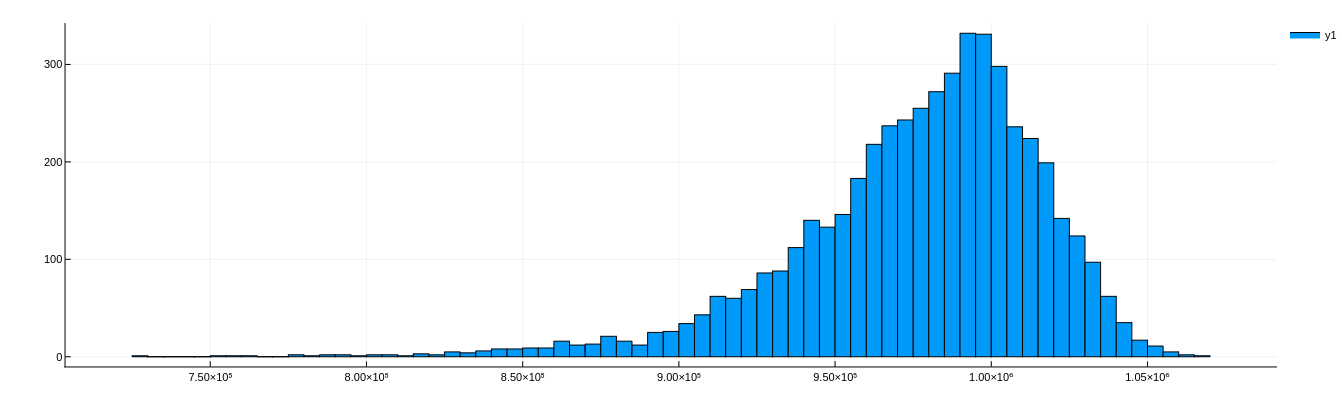

In [21]:
# Strategy: invest the same amount every day, sell it when it hits cagr of 10%. or a maximum of 1000 days
function simulate()
    runs::Int = 5000
    wallets::Vector{Float64} = Vector{Float64}(undef, runs)
    
    rateThreshold::Float64 = .1; investDays::Int = 365*3; redeemDays::Int=365; days = investDays + redeemDays; 
    μ::Float64=.1; σ::Float64=.3; ll = FastList{Tuple{Int, Float64, Float64}}(investDays+redeemDays+1000);
    s::Union{Vector{Float64}, Nothing}=Vector{Float64}(undef, days); 
        ϕ::Union{Vector{Float64}, Nothing}=Vector{Float64}(undef, days); dist::Union{Normal{Float64}, Nothing}=Normal(0, 1);
    
    for run::Int in 1:runs
        wallets[run] = oneRun(rateThreshold, investDays, redeemDays, μ, σ, ll, s, ϕ, dist)
        reset!(ll)
    end
    histogram(wallets)
    
end

function oneRun(rateThreshold::Float64, investDays::Int, redeemDays::Int, μ::Float64, σ::Float64, ll::FastList{Tuple{Int, Float64, Float64}}, 
        s::Union{Vector{Float64}, Nothing}=nothing, 
        ϕ::Union{Vector{Float64}, Nothing}=nothing, dist::Union{Normal{Float64}, Nothing}=nothing)
    days::Int = investDays+redeemDays
    amount::Int = 1000
    s = weiner(days, μ, σ, s, ϕ, dist)
#     daysToRedeem = Vector{Int}(undef, days)
#     fill!(daysToRedeem, 0)
#     display(doplot(collect(1:days), s))
    
    minWallet = 0
    wallet::Float64 = 0
    for day::Int in 1:days
        for node in ll
            (d::Int, price::Float64, num::Float64) = node.data
            rate::Float64 = r(price, s[day], (day-d)/365.0)
            if rate > rateThreshold
                wallet += s[day]*num
                del(ll, node)
#                 daysToRedeem[d] = day-d
            end
        end
        if day <= investDays
            wallet -= s[day]
            push!(ll, (day, s[day], amount/s[day]))
        end
        minWallet = min(wallet, minWallet)
    end
    # dispose all the stocks
    for node in ll
        (d::Int, price::Float64, num::Float64) = node.data
        wallet += s[end]*num
    end
#     display(plot(fit(Histogram, daysToRedeem, 0:10)))
    return wallet
end
ll = FastList{Tuple{Int, Float64}}(4000)
# oneRun(0.1, 3, 3, .1, .2, ll)
@time simulate()

In [ ]:
function foo()
    ll = MutableLinkedList{Float64}()
    for run in 1:10000*2000
        append!(ll, 3)
        pop!(ll)
    end
end
@time foo()

In [ ]:
methodswith(MutableLinkedList)

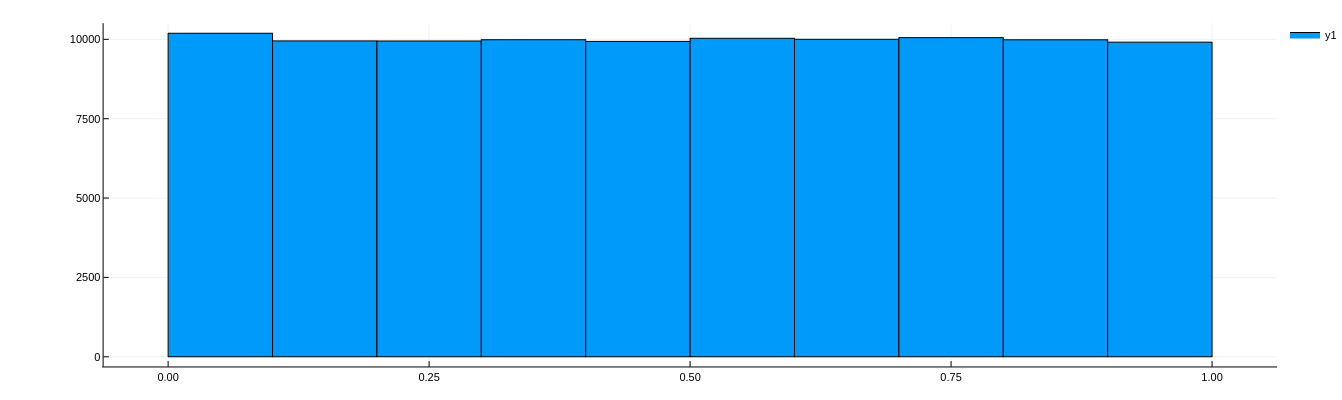

In [5]:
h = fit(Histogram, rand(100000))
plot(h)

In [22]:
conn

PostgreSQL connection (CONNECTION_OK) with parameters:
  user = sharath
  passfile = /home/sharath/.pgpass
  dbname = sharath
  port = 5432
  client_encoding = UTF8
  options = -c DateStyle=ISO,YMD -c IntervalStyle=iso_8601 -c TimeZone=UTC
  application_name = LibPQ.jl
  sslmode = prefer
  sslcompression = 0
  gssencmode = disable
  krbsrvname = postgres
  target_session_attrs = any